In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from scipy.stats import uniform, randint

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
os.chdir('C:\\Users\\akash\\OneDrive\\Desktop\\Acmegrade Data Science March_24 Files\\Mar 24 DS Day18 Projects\\PRJ Sales Forecasting')

In [3]:
dt = pd.read_csv('Train.csv')

In [4]:
print(dt.head())

  Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
0           FDA15         9.30          Low Fat         0.016047   
1           DRC01         5.92          Regular         0.019278   
2           FDN15        17.50          Low Fat         0.016760   
3           FDX07        19.20          Regular         0.000000   
4           NCD19         8.93          Low Fat         0.000000   

               Item_Type  Item_MRP Outlet_Identifier  \
0                  Dairy  249.8092            OUT049   
1            Soft Drinks   48.2692            OUT018   
2                   Meat  141.6180            OUT049   
3  Fruits and Vegetables  182.0950            OUT010   
4              Household   53.8614            OUT013   

   Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
0                       1999      Medium               Tier 1   
1                       2009      Medium               Tier 3   
2                       1999      Medium               Tier

In [5]:
print(dt.shape)

(8523, 12)


In [6]:
print(dt.columns)

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales'],
      dtype='object')


In [7]:
print(dt.describe())

       Item_Weight  Item_Visibility     Item_MRP  Outlet_Establishment_Year  \
count  7060.000000      8523.000000  8523.000000                8523.000000   
mean     12.857645         0.066132   140.992782                1997.831867   
std       4.643456         0.051598    62.275067                   8.371760   
min       4.555000         0.000000    31.290000                1985.000000   
25%       8.773750         0.026989    93.826500                1987.000000   
50%      12.600000         0.053931   143.012800                1999.000000   
75%      16.850000         0.094585   185.643700                2004.000000   
max      21.350000         0.328391   266.888400                2009.000000   

       Item_Outlet_Sales  
count        8523.000000  
mean         2181.288914  
std          1706.499616  
min            33.290000  
25%           834.247400  
50%          1794.331000  
75%          3101.296400  
max         13086.964800  


In [8]:
print(dt.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB
None


In [9]:
print(dt.apply(lambda x: len(x.unique())))

Item_Identifier              1559
Item_Weight                   416
Item_Fat_Content                5
Item_Visibility              7880
Item_Type                      16
Item_MRP                     5938
Outlet_Identifier              10
Outlet_Establishment_Year       9
Outlet_Size                     4
Outlet_Location_Type            3
Outlet_Type                     4
Item_Outlet_Sales            3493
dtype: int64


In [10]:
cat_col = [col for col in dt.columns if dt[col].dtype == 'object']

In [11]:
cat_col

['Item_Identifier',
 'Item_Fat_Content',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [12]:
cat_col.remove('Item_Identifier')
cat_col.remove('Outlet_Identifier')

In [13]:
cat_col

['Item_Fat_Content',
 'Item_Type',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [14]:
item_weight_mean = dt.pivot_table(values="Item_Weight", index='Item_Identifier')
miss_bool = dt['Item_Weight'].isnull()

for i, item in enumerate(dt['Item_Identifier']):
    if miss_bool[i]:
        if item in item_weight_mean.index:
            dt.at[i, 'Item_Weight'] = item_weight_mean.at[item, 'Item_Weight']
        else:
            dt.at[i, 'Item_Weight'] = dt['Item_Weight'].mean()

In [15]:
outlet_size_mode = dt.pivot_table(values='Outlet_Size', columns='Outlet_Type', aggfunc=(lambda x: x.mode()[0]))
miss_bool = dt['Outlet_Size'].isnull()
dt.loc[miss_bool, 'Outlet_Size'] = dt.loc[miss_bool, 'Outlet_Type'].apply(lambda x: outlet_size_mode[x])

In [16]:
dt['Item_Visibility'].replace(0, dt['Item_Visibility'].mean(), inplace=True)

In [17]:
dt['Item_Fat_Content'] = dt['Item_Fat_Content'].replace({'LF':'Low Fat', 'reg':'Regular', 'low fat':'Low Fat'})

In [18]:
dt['New_Item_Type'] = dt['Item_Identifier'].apply(lambda x: x[:2])
dt['New_Item_Type'] = dt['New_Item_Type'].map({'FD':'Food', 'NC':'Non-Consumable', 'DR':'Drinks'})
dt.loc[dt['New_Item_Type']=='Non-Consumable', 'Item_Fat_Content'] = 'Non-Edible'

In [19]:
dt['Outlet_Years'] = 2024 - dt['Outlet_Establishment_Year']

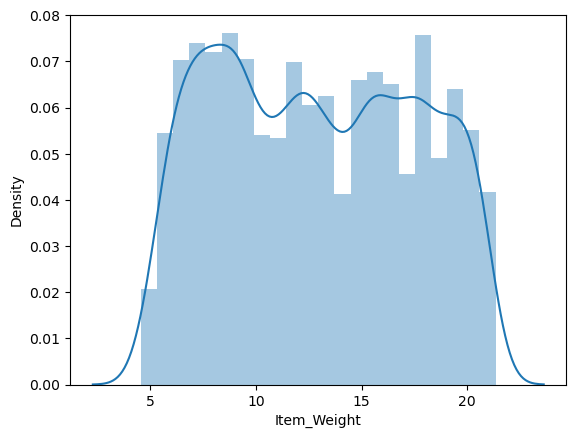

In [20]:
sns.distplot(dt['Item_Weight'])
plt.show()

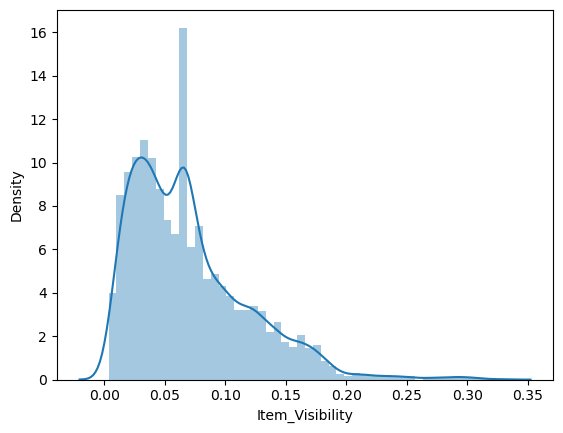

In [21]:
sns.distplot(dt['Item_Visibility'])
plt.show()

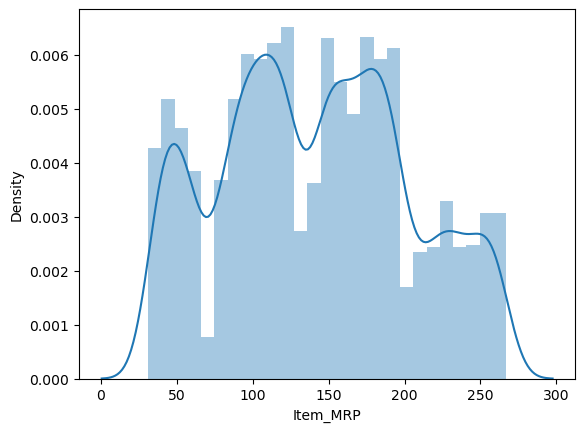

In [22]:
sns.distplot(dt['Item_MRP'])
plt.show()

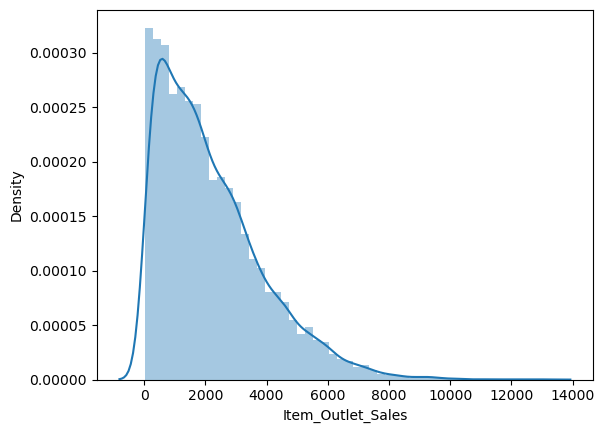

In [23]:
sns.distplot(dt['Item_Outlet_Sales'])
plt.show()

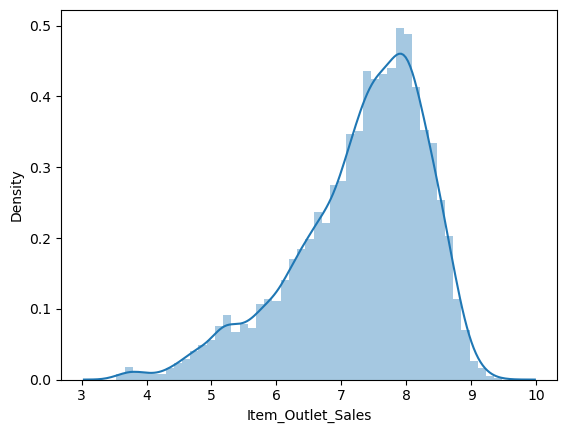

In [24]:
dt['Item_Outlet_Sales'] = np.log(1 + dt['Item_Outlet_Sales'])
sns.distplot(dt['Item_Outlet_Sales'])
plt.show()

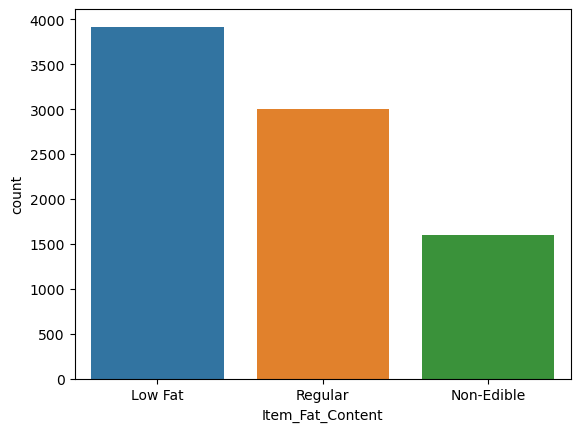

In [25]:
sns.countplot(x = dt["Item_Fat_Content"])
plt.show()

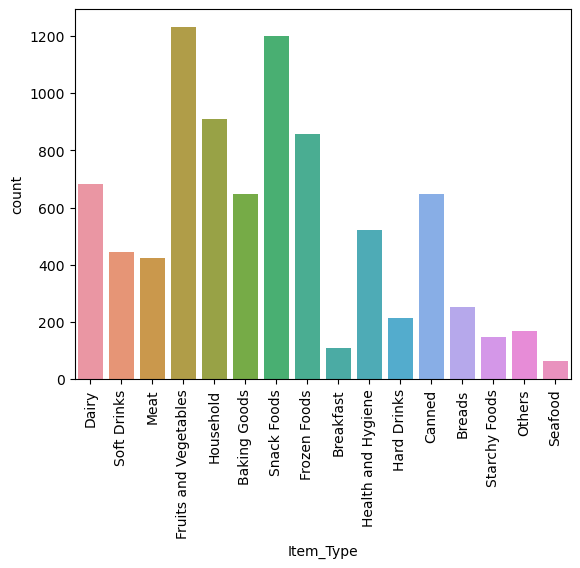

In [26]:
sns.countplot(x = dt["Item_Type"])
plt.xticks(rotation=90)
plt.show()

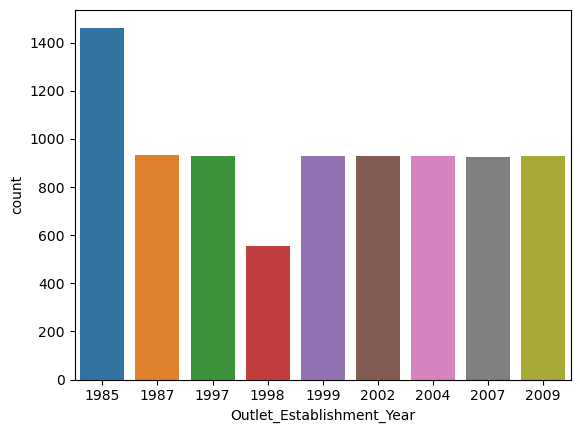

In [27]:
sns.countplot(x= dt['Outlet_Establishment_Year'])
plt.show()

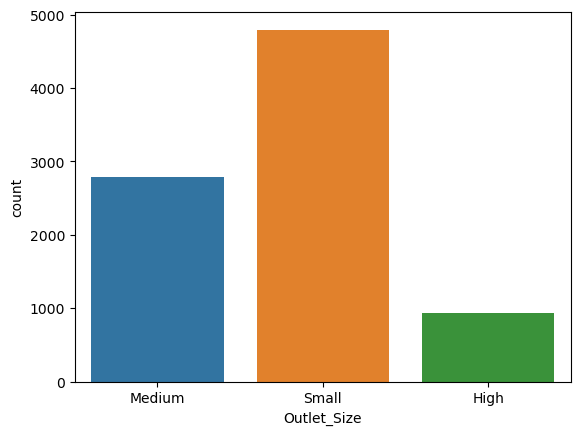

In [28]:
sns.countplot(x=dt['Outlet_Size'])
plt.show()

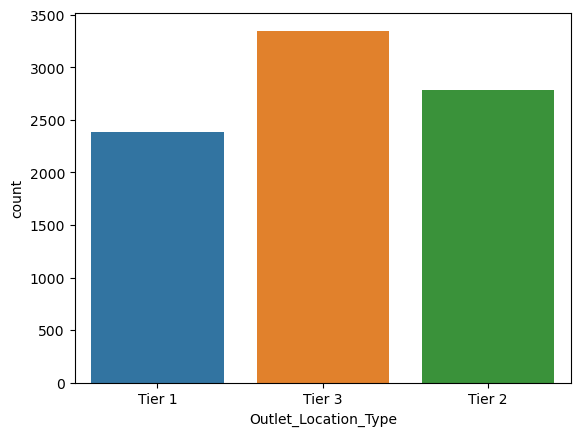

In [29]:
sns.countplot(x=dt['Outlet_Location_Type'])
plt.show()

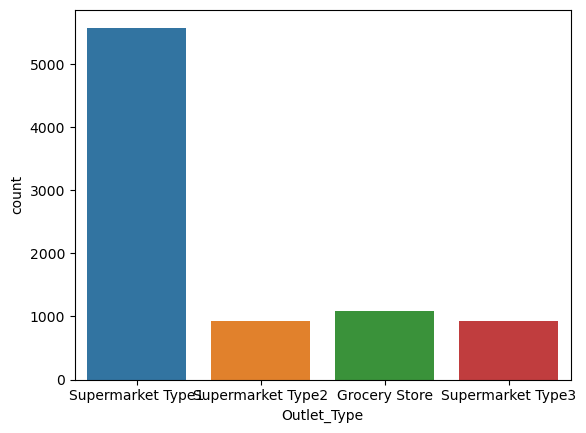

In [30]:
sns.countplot(x= dt['Outlet_Type'])
plt.show()

In [31]:
le = LabelEncoder()
dt['Outlet'] = le.fit_transform(dt['Outlet_Identifier'])

cat_col = ['Item_Fat_Content', 'Item_Type', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'New_Item_Type']
for col in cat_col:
    dt[col] = le.fit_transform(dt[col])

dt = pd.get_dummies(dt, columns=['Item_Fat_Content', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'New_Item_Type'], dtype=int)

X = dt.drop(columns=['Outlet_Establishment_Year', 'Item_Identifier', 'Outlet_Identifier', 'Item_Outlet_Sales'])
y = dt['Item_Outlet_Sales']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(5966, 22) (2557, 22) (5966,) (2557,)


In [33]:
def train(model, X, y):
    model.fit(X, y)
    pred = model.predict(X)
    cv_score = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=5)
    print("Model Report")
    print(f'Scoring - neg_mean_squared_error: {cv_score}')
    cv_score = np.abs(np.mean(cv_score))
    print(f'ABS Average of neg_mean_squared_error: {cv_score}')
    cv_score = cross_val_score(model, X, y, cv=5)
    print(f'R2 Score: {cv_score}')
    cv_score = np.mean(cv_score)
    print(f'Average R2 Score: {cv_score}')
    print(f'R2_Score: {r2_score(y, pred)}')

In [34]:
model = LinearRegression()
train(model, X_train, y_train)

Model Report
Scoring - neg_mean_squared_error: [-0.29271824 -0.27380022 -0.28650685 -0.28450916 -0.28157839]
ABS Average of neg_mean_squared_error: 0.28382257489217816
R2 Score: [0.69534635 0.73185961 0.7163057  0.73463311 0.72780316]
Average R2 Score: 0.7211895851380341
R2_Score: 0.7232624990443841


In [35]:
model = Ridge()
train(model, X_train, y_train)

Model Report
Scoring - neg_mean_squared_error: [-0.29241213 -0.27413941 -0.2869929  -0.28451826 -0.2818739 ]
ABS Average of neg_mean_squared_error: 0.28398732024941487
R2 Score: [0.69566494 0.73152743 0.71582442 0.73462463 0.7275175 ]
Average R2 Score: 0.7210317841099343
R2_Score: 0.7230806625087238


In [36]:
model = Lasso()
train(model, X_train, y_train)

Model Report
Scoring - neg_mean_squared_error: [-0.72314998 -0.75701947 -0.75847666 -0.74093272 -0.78787083]
ABS Average of neg_mean_squared_error: 0.7534899315973709
R2 Score: [0.24736402 0.25862917 0.24896908 0.30891853 0.23837923]
Average R2 Score: 0.2604520071591053
R2_Score: 0.26227683517122646


In [37]:
model = DecisionTreeRegressor()
train(model, X_train, y_train)

Model Report
Scoring - neg_mean_squared_error: [-0.56654337 -0.54324281 -0.54331534 -0.55034161 -0.55905263]
ABS Average of neg_mean_squared_error: 0.5524991540548724
R2 Score: [0.40759519 0.4513034  0.4602814  0.48859138 0.46281229]
Average R2 Score: 0.4541167339143115
R2_Score: 1.0


In [38]:
model = RandomForestRegressor()
train(model, X_train, y_train)

Model Report
Scoring - neg_mean_squared_error: [-0.31086279 -0.28171996 -0.30646084 -0.29056563 -0.30393935]
ABS Average of neg_mean_squared_error: 0.2987097130104206
R2 Score: [0.67612081 0.72190014 0.69451329 0.72907114 0.70490926]
Average R2 Score: 0.7053029286490914
R2_Score: 0.9593075707458918


In [39]:
model = ExtraTreesRegressor()
train(model, X_train, y_train)

Model Report
Scoring - neg_mean_squared_error: [-0.33315955 -0.31083096 -0.31969319 -0.31634615 -0.32021913]
ABS Average of neg_mean_squared_error: 0.3200497952851305
R2 Score: [0.65417733 0.6955147  0.68326661 0.69937092 0.69341608]
Average R2 Score: 0.6851491285326243
R2_Score: 1.0


In [40]:
model = LGBMRegressor()
train(model, X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 806
[LightGBM] [Info] Number of data points in the train set: 5966, number of used features: 22
[LightGBM] [Info] Start training from score 7.295854
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000344 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 813
[LightGBM] [Info] Number of data points in the train set: 4772, number of used features: 22
[LightGBM] [Info] Start training from score 7.292207
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

In [41]:
model = XGBRegressor()
train(model, X_train, y_train)

Model Report
Scoring - neg_mean_squared_error: [-0.34171575 -0.29940184 -0.32970416 -0.31770428 -0.32953668]
ABS Average of neg_mean_squared_error: 0.3236125411964996
R2 Score: [0.644351   0.70678721 0.67353245 0.70367142 0.68144273]
Average R2 Score: 0.6819569626413553
R2_Score: 0.9120531911594594


In [42]:
rf = RandomForestRegressor()
param_grid = {
    'max_features': ['auto', 'sqrt'],
    'max_depth': [int(x) for x in np.linspace(5, 30, num=6)],
    'min_samples_split': [2, 5, 10, 15, 100],
    'min_samples_leaf': [1, 2, 5, 10]
}
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, scoring='neg_mean_squared_error', n_iter=10, cv=5, verbose=2, random_state=42, n_jobs=-1)
rf_random.fit(X_train, y_train)

print(rf_random.best_params_)
print(rf_random.best_score_)
predictions = rf_random.predict(X_test)
print(r2_score(y_test, predictions))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'min_samples_split': 100, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 5}
-0.26877859981536006
0.7258167624537042


In [43]:
params = {
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3),
    "max_depth": randint(2, 6),
    "n_estimators": randint(100, 150),
    "subsample": uniform(0.6, 0.4)
}
lgb = LGBMRegressor()
lgb_random = RandomizedSearchCV(estimator=lgb, param_distributions=params, scoring='neg_mean_squared_error', n_iter=10, cv=5, verbose=2, random_state=42, n_jobs=1)
lgb_random.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000453 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 813
[LightGBM] [Info] Number of data points in the train set: 4772, number of used features: 22
[LightGBM] [Info] Start training from score 7.292207
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000751 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 811
[LightGBM] [Info] Number of data points in the train set: 4773, number of used features: 22
[LightGBM] [Info] Start training from score 7.297274
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 807
[LightGBM] [Info] Number of data points in the train set: 4773, number of used features: 22
[LightGBM] [Info] Start training from score 7.289242
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV] END gamma=0.4692763545078751, learning_rate=0.030233629752304297, max_depth=5, n_estimators=120, subsample=0.8469926038510867; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Accura

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000426 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 807
[LightGBM] [Info] Number of data points in the train set: 4773, number of used features: 22
[LightGBM] [Info] Start training from score 7.289242
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV] END gamma=0.19993048585762774, learning_rate=0.04399969896408463, max_depth=5, n_estimators=115, subsample=0.6931085361721216; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000436 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 807
[LightGBM] [Info] Number of data points in the train set: 4773

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV] END gamma=0.0453032172664104, learning_rate=0.2155158027999262, max_depth=5, n_estimators=102, subsample=0.9439761626945282; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 813
[LightGBM] [Info] Number of data points in the train set: 4773, 

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV] END gamma=0.0453032172664104, learning_rate=0.2155158027999262, max_depth=5, n_estimators=102, subsample=0.9439761626945282; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 807
[LightGBM] [Info] Number of data points in the train set: 4773, number of used features: 22
[LightGBM] [Info] Start training fro

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 811
[LightGBM] [Info] Number of data points in the train set: 4773, number of used features: 22
[LightGBM] [Info] Start training from score 7.297274
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[LightGBM] [Warning] Unknown parameter: gamma
[CV] END gamma=0.34015376929388985, learning_rate=0.16514977559086289, max_depth=3, n_estimators=103, subsample=0.9768807022739411; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 813
[LightGBM] [Info] Number of data points in the train set: 4772, number of used features: 22
[LightGBM] [Info] Start training from score 7.292207
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Warning] Unknown parameter: gamma
[CV] END gamma=0.28164410892276964, learning_rate=0.14562495076197482, max_depth=3, n_estimators=101, subsample=0.8736932106048627; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000719 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 807
[LightGBM] [Info] Number of data points in the train set: 4773, number of used features: 22
[LightGBM] [Info] Start training from score 7.289242
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000675 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 809
[LightGBM] [Info] Number of data points in the train set: 4773, number of used features: 22
[LightGBM] [Info] Start training from score 7.307082
[LightGBM] [Warning] Unknown parameter: gamma
[CV] END gamma=0.22007624686980065, learning_rate=0.06661147045343364, max_depth=2, n_estimators=107, subsample=0.6137554084460873; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000783 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 806
[LightGBM] [Info] Number of data points in the train set: 5966, number of used features: 22
[LightGBM] [Info] Start training from 

RandomizedSearchCV(cv=5, estimator=LGBMRegressor(), n_jobs=1,
                   param_distributions={'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000024526FD3CA0>,
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000024526FE2100>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000024525F48D00>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000024526FE26A0>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000024526FF70A0>},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [44]:
print("Best parameters found: ", lgb_random.best_params_)
print("Best score: ", lgb_random.best_score_)

Best parameters found:  {'gamma': 0.22007624686980065, 'learning_rate': 0.06661147045343364, 'max_depth': 2, 'n_estimators': 107, 'subsample': 0.6137554084460873}
Best score:  -0.2657969451962804


In [45]:
predictions = lgb_random.predict(X_test)
print("R2 Score:", r2_score(y_test, predictions))
print("Mean Squared Error:", mean_squared_error(y_test, predictions))

[LightGBM] [Warning] Unknown parameter: gamma
R2 Score: 0.730330477796805
Mean Squared Error: 0.28433999238463964


In [46]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Extra Trees": ExtraTreesRegressor(),
    "LightGBM": LGBMRegressor(**lgb_random.best_params_),
    "XGBoost": XGBRegressor(),
}

for name, model in models.items():
    print(f"Training and evaluating {name}")
    train(model, X_train, y_train)
    predictions = model.predict(X_test)
    print(f"{name} R2 Score:", r2_score(y_test, predictions))
    print(f"{name} Mean Squared Error:", mean_squared_error(y_test, predictions))
    print("\n")

Training and evaluating Linear Regression
Model Report
Scoring - neg_mean_squared_error: [-0.29271824 -0.27380022 -0.28650685 -0.28450916 -0.28157839]
ABS Average of neg_mean_squared_error: 0.28382257489217816
R2 Score: [0.69534635 0.73185961 0.7163057  0.73463311 0.72780316]
Average R2 Score: 0.7211895851380341
R2_Score: 0.7232624990443841
Linear Regression R2 Score: 0.7136391970550767
Linear Regression Mean Squared Error: 0.3019393065385647


Training and evaluating Ridge Regression
Model Report
Scoring - neg_mean_squared_error: [-0.29241213 -0.27413941 -0.2869929  -0.28451826 -0.2818739 ]
ABS Average of neg_mean_squared_error: 0.28398732024941487
R2 Score: [0.69566494 0.73152743 0.71582442 0.73462463 0.7275175 ]
Average R2 Score: 0.7210317841099343
R2_Score: 0.7230806625087238
Ridge Regression R2 Score: 0.7132086988032391
Ridge Regression Mean Squared Error: 0.30239322461076307


Training and evaluating Lasso Regression
Model Report
Scoring - neg_mean_squared_error: [-0.72314998 -0.

Model Report
Scoring - neg_mean_squared_error: [-0.34171575 -0.29940184 -0.32970416 -0.31770428 -0.32953668]
ABS Average of neg_mean_squared_error: 0.3236125411964996
R2 Score: [0.644351   0.70678721 0.67353245 0.70367142 0.68144273]
Average R2 Score: 0.6819569626413553
R2_Score: 0.9120531911594594
XGBoost R2 Score: 0.6790166791151621
XGBoost Mean Squared Error: 0.33844534699483303




In [47]:
import joblib

best_model = lgb_random.best_estimator_
joblib.dump(best_model, 'best_sales_forecasting_model.pkl')

['best_sales_forecasting_model.pkl']

In [48]:
print("Sales forecasting project completed.")
print("The best model is saved as 'best_sales_forecasting_model.pkl'.")
print("Use the saved model for future predictions on new data.")

Sales forecasting project completed.
The best model is saved as 'best_sales_forecasting_model.pkl'.
Use the saved model for future predictions on new data.
